<a href="https://colab.research.google.com/github/SethJorissen/ANM_anomalies_project/blob/main/ANM_anomalies_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANM anomaly detection project - phase 2

Tsinghua 2023, produced by Aris Dressino and Seth Jorissen

## 1. initial set up

- fetch data for analysis
- import needed libraries

In [1]:
# fetch phase 1 and 2 data from github to colab working directory - run once
# consider using another method if working from local client
%%capture
#import shutil
#shutil.rmtree('/content/phase1')
!apt install subversion
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase1
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase2

In [2]:
# needed libraries
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
from tqdm import tqdm
from typing import Dict, List
from typing import List, Dict, Tuple, Set
from scipy.stats import pearsonr
import shutil
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping

##2. Exploratory data analysis

- provide summary statistics and relevant analysis of the data
- plot relevant features of the dataset against timestamp



In [3]:
# import train set
# Set the path to the directory containing the CSV files
path = 'phase2/dataset/train/processed'

# Get a list of all CSV files in the directory
files = glob.glob(os.path.join(path, '*.csv'))

df_list = []
# Iterate over each file, read it into a DataFrame, and add a new column with the filename
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the filename without the extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df['service'] = filename
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
train = pd.concat(df_list, ignore_index=True)

train.head(5)

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s,service
0,1647619260,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,28.0,0.0,256.0,0.0,0.546339,0.005,0.0,shippingservice-1
1,1647619320,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,28.0,0.0,256.0,0.0,0.354200,0.005,0.0,shippingservice-1
2,1647619380,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,28.0,0.0,256.0,0.0,0.548564,0.005,0.0,shippingservice-1
3,1647619440,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,28.0,0.0,256.0,0.0,0.342553,0.005,0.0,shippingservice-1
4,1647619500,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,28.0,0.0,256.0,0.0,0.447354,0.005,0.0,shippingservice-1


In [4]:
# describe numerical metrics of train dataset
pd.set_option('display.max_columns', None)
train.describe()

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,container_fs_inodes_free./dev/vda1,container_fs_sector_reads./dev/vda1,container_network_transmit_packets.eth0,container_cpu_usage_seconds,container_cpu_cfs_throttled_periods,container_file_descriptors,container_cpu_cfs_throttled_seconds,container_fs_reads./dev/vda,container_fs_reads./dev/vda1,container_memory_failures.container.pgfault,container_memory_failures.container.pgmajfault,container_memory_failures.hierarchy.pgfault,container_memory_failures.hierarchy.pgmajfault,container_memory_max_usage_MB,container_fs_inodes./dev/vda1,container_fs_reads_MB./dev/vda,container_last_seen,container_cpu_user_seconds,container_fs_limit_MB./dev/vda1,container_fs_io_time_weighted_seconds./dev/vda1,container_fs_sector_writes./dev/vda1,container_network_receive_packets.eth0,container_memory_working_set_MB,container_fs_io_current./dev/vda1,container_memory_usage_MB,container_fs_usage_MB./dev/vda1,container_sockets,container_fs_io_time_seconds./dev/vda1,container_memory_failcnt,container_spec_cpu_quota,container_fs_writes./dev/vda,container_fs_writes./dev/vda1,container_ulimits_soft.max_open_files,container_network_receive_MB.eth0,container_tasks_state.iowaiting,container_tasks_state.running,container_tasks_state.sleeping,container_tasks_state.stopped,container_tasks_state.uninterruptible,container_fs_read_seconds./dev/vda1,container_memory_rss,container_start_time_seconds,container_memory_mapped_file,container_spec_memory_reservation_limit_MB,container_memory_cache,container_cpu_cfs_periods,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s
count,6.043800e+04,60438.0,57560.000000,57560.000000,57560.0,60438.0,60438.0,57560.0,57560.0,57560.0,57560.0,57560.0,60438.000000,57560.000000,57560.000000,57560.000000,57560.000000,57560.000000,57560.0,57560.000000,57560.000000,57560.000000,57560.000000,57560.000000,57560.000000,55160.000000,5.756000e+04,57560.000000,57560.000000,57560.0,57560.0,60438.000000,57560.000000,57560.0,57560.000000,57560.000000,57560.000000,57560.0,57560.000000,57560.000000,57560.0,57560.0,5.516000e+04,60438.000000,57560.0,57560.0,57560.0,57560.0,57560.0,57560.0,5.756000e+04,5.756000e+04,5.756000e+04,57560.0,5.756000e+04,57560.000000,57560.0,57560.0,57560.000000,60438.0,57560.000000,57560.0,60438.000000,57560.000000,57560.0
mean,1.647662e+09,0.0,206.700000,368.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,924.801215,0.206512,0.232922,36.786211,0.015082,0.092393,0.0,187.468016,0.017391,187.468016,0.017391,345.199549,0.000718,0.001766,1.647662e+09,0.119992,604630.738281,0.0,0.0,980.062690,64.047569,0.0,73.251540,83.679335,5.438988,0.0,0.750000,37000.000000,0.0,0.0,9.011200e+05,0.168638,0.0,0.0,0.0,0.0,0.0,0.0,4.827034e+07,1.647205e+09,4.181940e+06,0.0,1.566113e+07,113.878423,100000.0,0.0,25.588870,0.0,368.125000,0.0,1.341939,0.060221,0.0
std,2.492441e+04,0.0,95.695972,280.152678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1633.733856,0.260263,0.758866,48.356892,0.055175,5.503762,0.0,616.697959,1.403371,616.697959,1.403371,288.281897,0.046823,0.114247,2.492442e+04,0.132230,0.000000,0.0,0.0,1533.730644,53.881059,0.0,54.288065,160.741765,2.885062,0.0,2.576357,12884.210647,0.0,0.0,3.510187e+05,0.280004,0.0,0.0,0.0,0.0,0.0,0.0,5.436171e+07,1.479419e+05,5.950796e+06,0.0,7.325586e+06,97.499338,0.0,0.0,4.989798,0.0,280.152678,0.0,1.425130,0.100049,0.0
min,1.647619e+09,0.0,102.000000,128.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.500000,0.000000,0.000000,7.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000

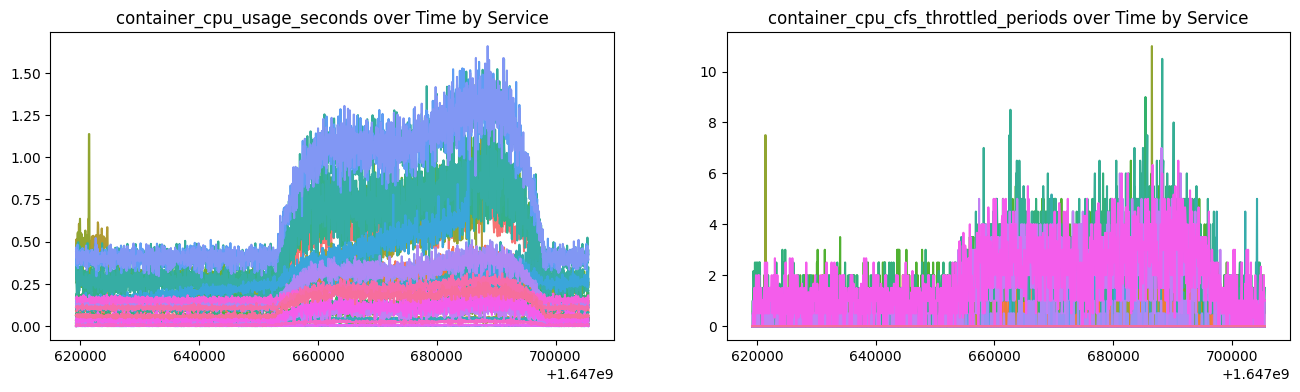

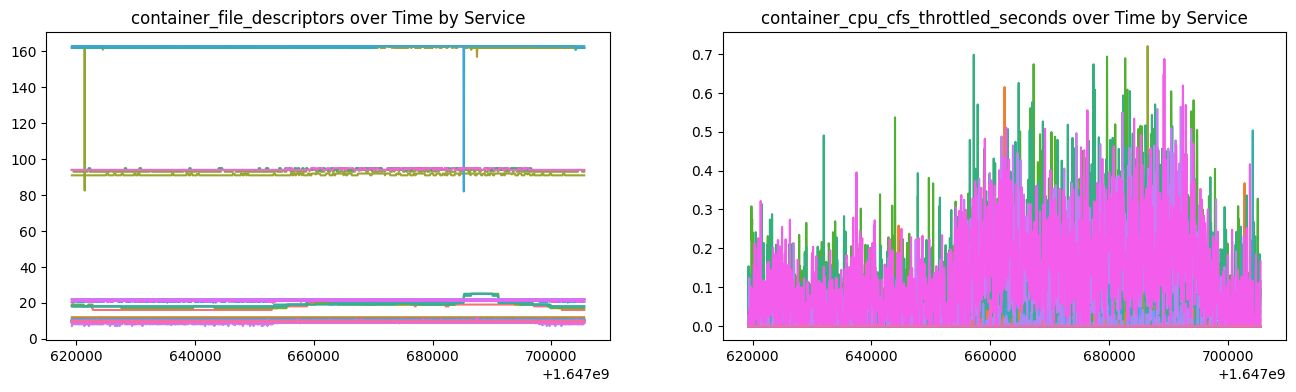

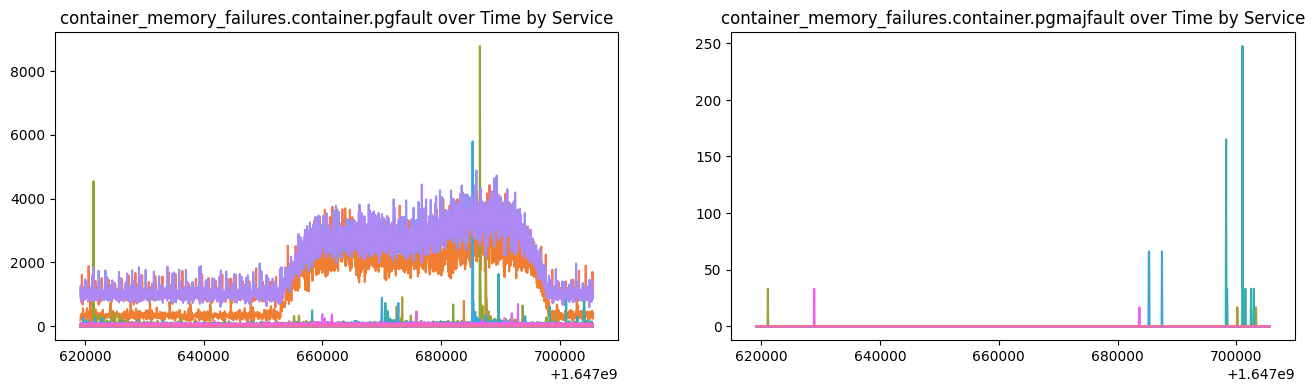

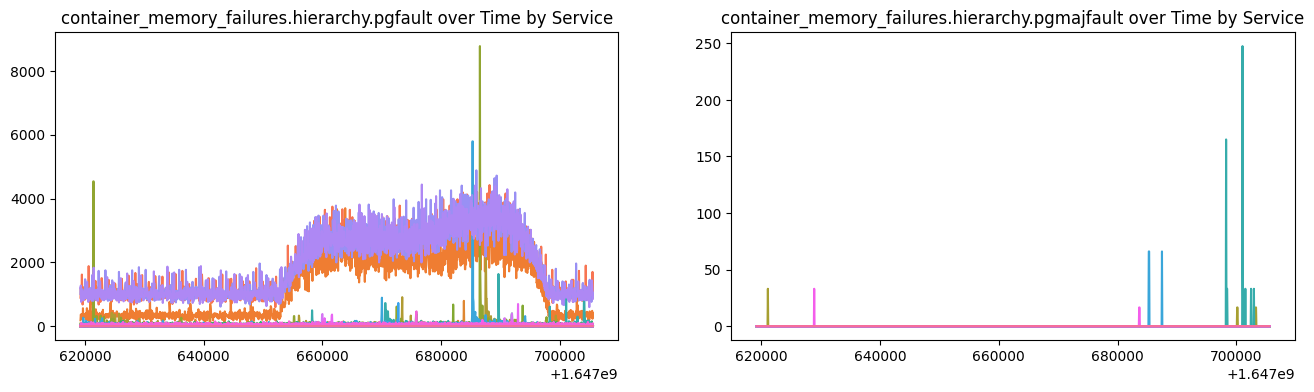

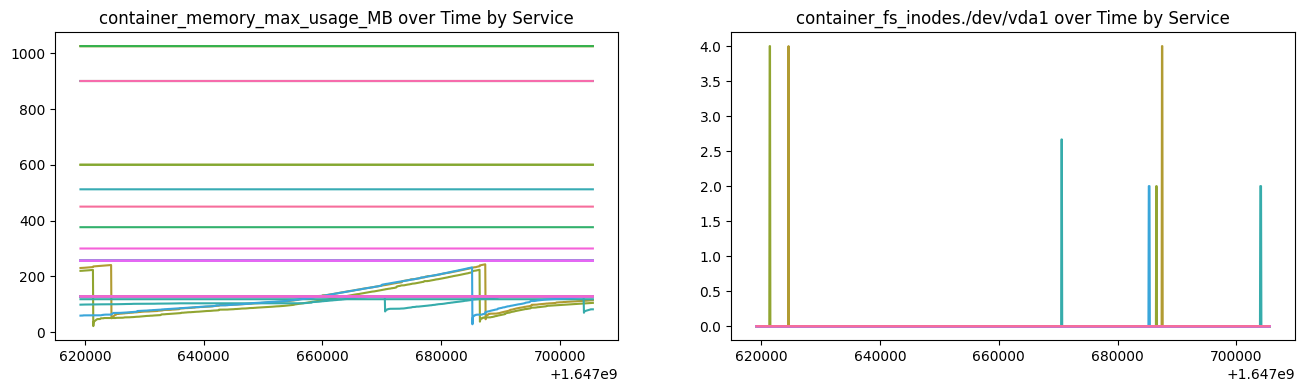

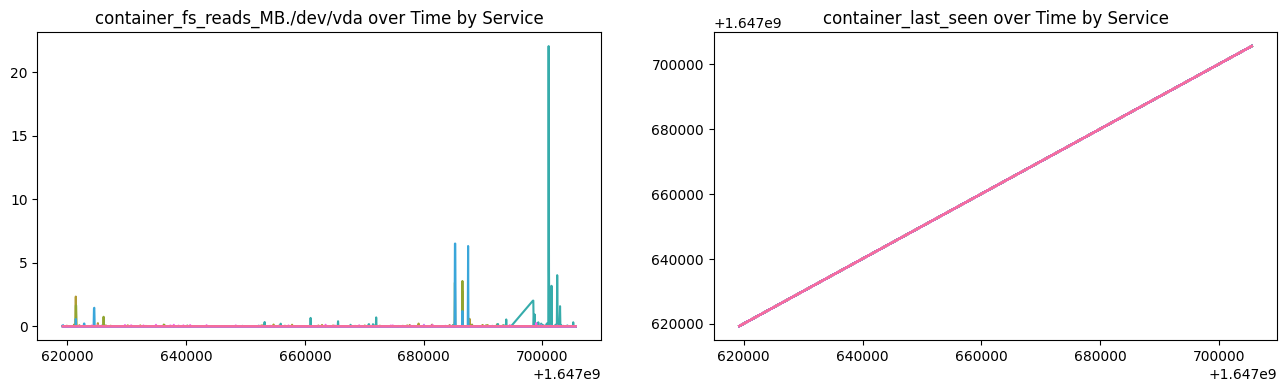

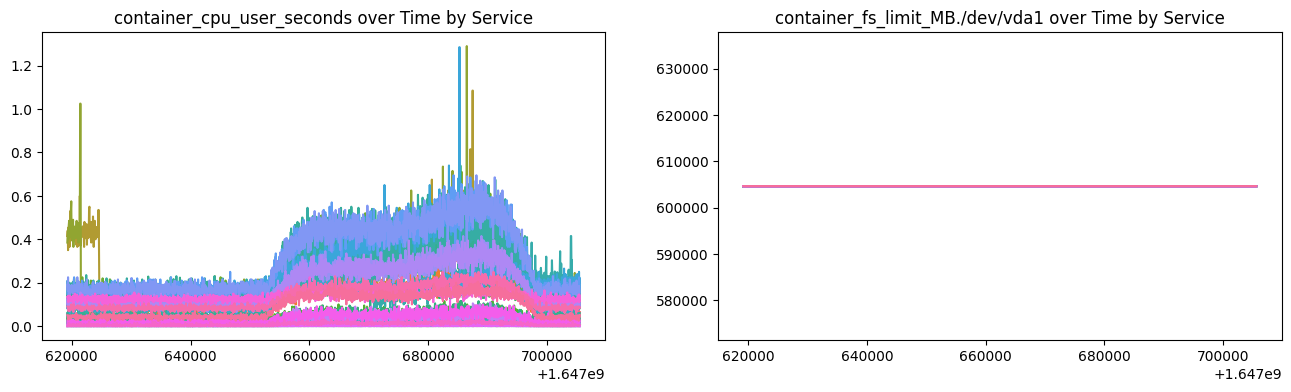

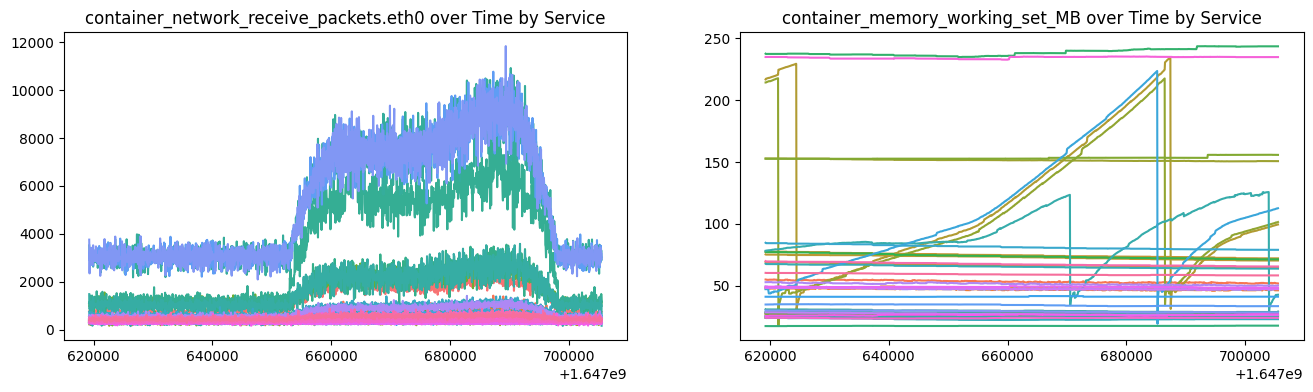

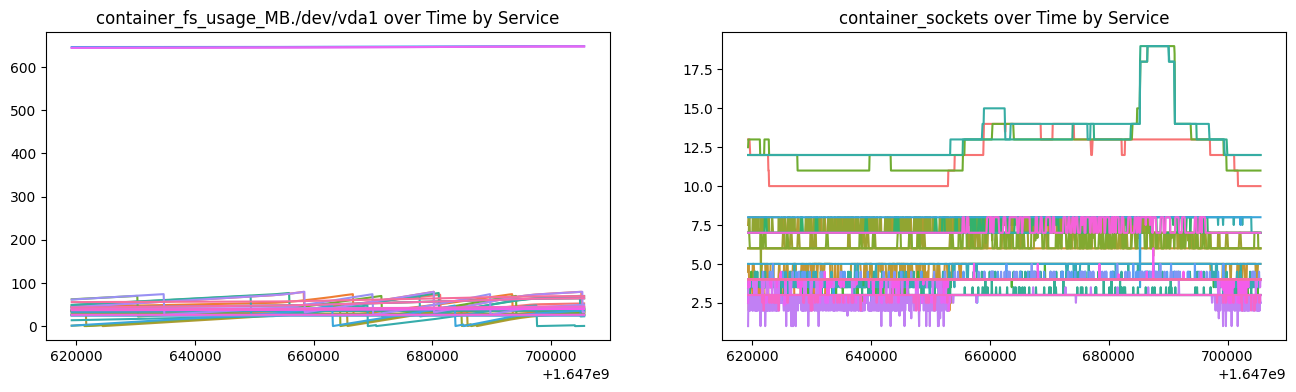

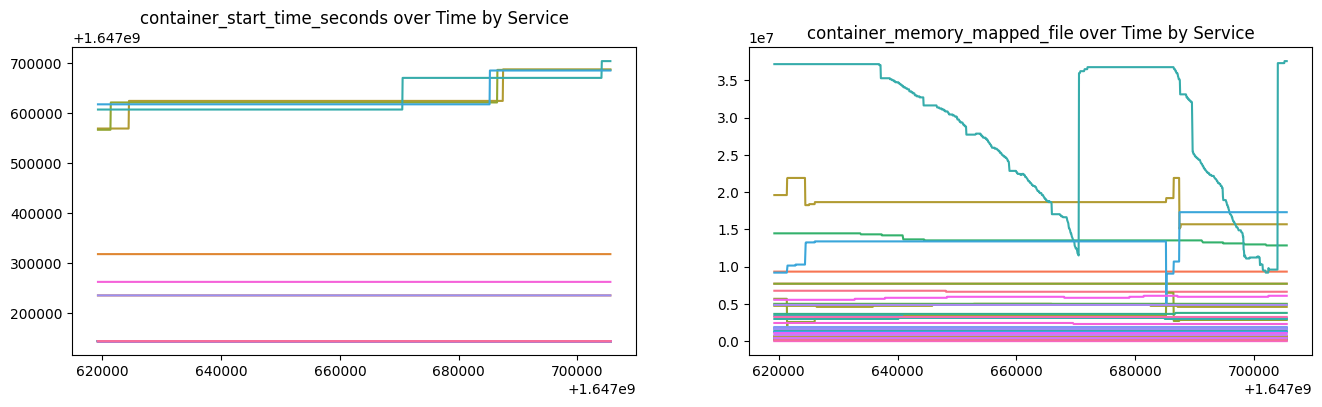

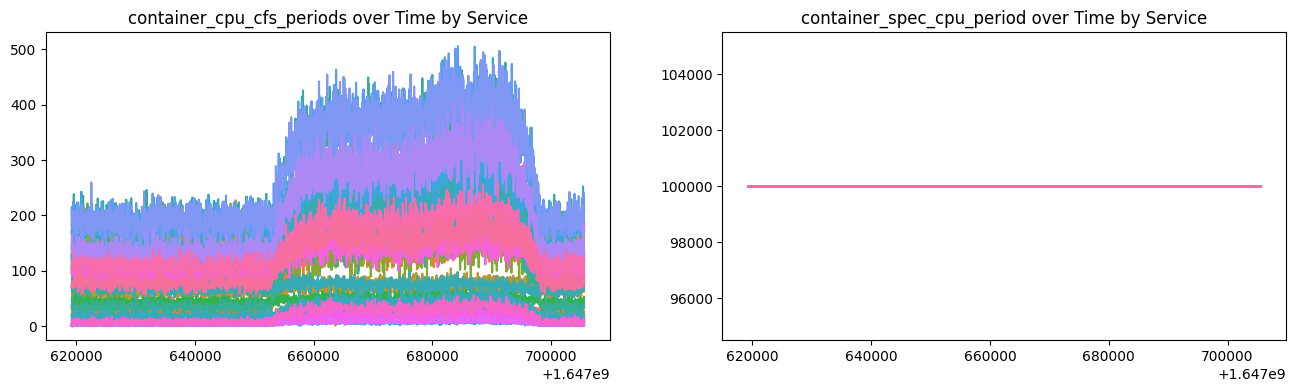

In [5]:
# Loop over all columns in the DataFrame except "timestamp" and "service"
cols = train.columns.drop(["timestamp", "service"])
for i in range(0, len(cols), 2):
    col1 = cols[i]
    col2 = cols[i+1] if i+1 < len(cols) else None

    # Check if all values in the column are 0 or the same value
    if (len(train[col1].unique()) == 1 or train[col1].sum() == 0) or (not col2 or (len(train[col2].unique()) == 1 or train[col2].sum() == 0)):
        continue

    # Check if the values are equal when grouped by service for both columns
    if col2:
        grouped1 = train.groupby('service')[col1].nunique()
        grouped2 = train.groupby('service')[col2].nunique()
        if len(grouped1.unique()) == 1 or len(grouped2.unique()) == 1:
            continue
        
    # Create a new row of subplots with 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Create the first plot in the left column
    sns.lineplot(x="timestamp", y=col1, hue="service", data=train, ax=axs[0])
    axs[0].set_title(f"{col1} over Time by Service")

    # Remove the legend from the first plot
    axs[0].get_legend().remove()

    # Create the second plot in the right column if there is a second column
    if col2:
        sns.lineplot(x="timestamp", y=col2, hue="service", data=train, ax=axs[1])
        axs[1].set_title(f"{col2} over Time by Service")

        # Remove the legend from the second plot
        axs[1].get_legend().remove()

    # Remove axis labels from all subplots
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Set the height of all subplots to the same value
    fig.subplots_adjust(hspace=0.4)

    # Add a border to the row of subplots
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    # Show the row of subplots
    plt.show()



##3. Anomaly Localization

This model first creates an anomaly detection model for all microservices. This model will return a series of anomaly scores over time.

Then a root cause analasis starts. The edges and nodes of the topology graph will be given weights. The nodes of this graph will be ranked by Random Walk.

###3.1 Data management

This class will prepare the data in the test/train folders. Given a folder it will load all csv files and and put them in a dictionary with their name as key. It gets rid of NaN values and removes irrelavent columns. It also normalizes the data with the mean and std of the non anomalous timestamps. For the traindata these are all timestamps and for the test data they are the first 15 timestamps.

In [6]:
class DataManager:
    def __init__(self, data_path: str, train: bool = False, ignore_columns=None):
        if ignore_columns is None:
            ignore_columns = [
                'timestamp',
                'container_start_time_seconds',
                'container_last_seen']
        self.data_path = data_path
        self.ignore_columns = ignore_columns
        self.train = train

        # Load from file
        self.data = {}
        self.columns = []
        self.__load()

    def __fill_na(self, df: pd.DataFrame):
        if self.train:
            df.interpolate(method='linear', inplace=True)
        df.fillna(0.0, inplace=True)

    def __normalize_data(self, data: np.ndarray):
        # Subtract the mean from each column
        if self.train:
          mean = np.mean(data, axis=0)
          std = np.std(data, axis=0)
          normalized_data = (data - mean) / (std + 1e-8)
        else:
          mean = np.mean(data[:15], axis=0)
          std = np.std(data[:15], axis=0)
          normalized_data = (data - mean) / (std + 1e-8)

        return normalized_data

    def __load(self):
        for file in os.listdir(self.data_path):
            if not file.endswith('.csv'):
                continue

            cur_df = pd.read_csv(os.path.join(self.data_path, file), engine='c')
            self.__fill_na(cur_df)
            self.columns = sorted([i for i in cur_df.columns.values if i not in self.ignore_columns])
            raw_data = cur_df[self.columns].values

            # Normalize the data to have the same mean distribution
            normalized_data = self.__normalize_data(raw_data)

            self.data[file[:-4]] = normalized_data

    def get(self, s: str) -> np.ndarray:
        return self.data[s]


###3.2 Anomaly detection

The anomaly detection model uses two classes. We also have two different detectors which ended up giving the best results:

- $GraphBasedDetector$ uses the Local Outlier Factor from sickit learn. maps the output scores between 0 and 1 and scales themon the mean of the samples before the 15 minute timestamp.

- $LSTMAEDetector$ holds a LSTM AE to detect anomalies in a microservice. Before fitting the model, it first prepares the input data creating sequences. Then it defines the model and fits it on the data. Finally the loss is scaled on the mean of the samples before the 15 minute timestamp. The anomaly score is defined by the reconstruction loss.

- The anomaly detector class will create and fit the Detectors of all microservices. When detecting an anomoly, it will call the detector of all microservices and return their anomaly scores.





In [11]:
# LOCAL OUTLIER FACTOR

from sklearn.neighbors import LocalOutlierFactor

class LOF:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = LocalOutlierFactor(contamination='auto', novelty=True)
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        scores = self.detector.decision_function(data)
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        anomaly_scores /= np.mean(anomaly_scores[:15])
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, LOF] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = LOF()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def detect(self, data: DataManager):
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)
            assert type(detect_result) == np.ndarray
            result[k] = detect_result

        return result


In [8]:
# LSTM-AE detector
def to_sequences(x, seq_size=1):
    x_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x[i:(i+seq_size)])

    return np.array(x_values)


class LSTMAEDetector:
    def __init__(self):
        self.model = Sequential()
        self.med_loss = 1

    def fit(self, data: np.ndarray):
        train_x = to_sequences(data, 10)

        self.model.add(LSTM(128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
        self.model.add(Dropout(rate=0.2))
        self.model.add(LSTM(32, return_sequences=False))
        self.model.add(Dropout(rate=0.2))
        self.model.add(RepeatVector(train_x.shape[1]))
        self.model.add(LSTM(32, return_sequences=True))
        self.model.add(Dropout(rate=0.2))
        self.model.add(LSTM(128, return_sequences=True))
        self.model.add(Dropout(rate=0.2))
        self.model.add(TimeDistributed(Dense(train_x.shape[2])))
        self.model.compile(optimizer='adam', loss='mae')

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', start_from_epoch=10)

        self.model.fit(train_x, train_x, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[earlystop])

    def decision_function(self, data: np.ndarray):
        test_x = to_sequences(data, 10)

        predict = self.model.predict(test_x, verbose=0)
        loss = (np.mean(np.abs(predict - test_x), axis=(1, 2)))
        return loss / np.mean(loss[:-15])


class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, LSTMAEDetector] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = LSTMAEDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def detect(self, data: DataManager):
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            scores = self.detector_dict[k].decision_function(v)

            assert type(scores) == np.ndarray
            anomaly_scores[k] = scores

        return anomaly_scores

###3.3 Root cause localization
The root cause localization will rank all microservices based on the probability that they are the root cause of the anomaly. The ranker has to be initialized with an anomalydetector. To start ranking the microservices their anomaly scores are calculated. Afterwards, the algorithm will use following scoring formula to perform a Random Walk:

$$v_{t+1} = cv_tP + (1-c)u$$

where $v$ holds the score of all nodes, $P$ is a matrix holding the weights of all the steps between the nodes and $u$ is a vector with for each microservice, the anomaly score. The score of each node is instantiated as $1 / number$ $containers$. Steps are defined by the edges of the topology. The forward steps are defined by the correlation between anomaly scores of the two containers after the (relative) 15 minute timestamp. The backward step is defined as the difference between the correlation before the 15 minutes timestamp and after it. This is because when a parents score normally is influenced by a child the correlation is high but when the anomaly occurs at the parent the correlation will go down. In this case we want to step to the parent. The final step is the self step. This is defined as the difference between the incomming and the outgoing steps. This makes sure that if the correlation drops after the node there is a possibility to stay in the node. Both the backward step and the self step can be influenced by a factor. There is also a chance $1-c$ to do a random teleportation. This is determined by $u$ and is defined by the average anomaly score.

In [9]:
def find_correlation(container1: np.ndarray, container2: np.ndarray):
    corr = []
    for i in range(container1.shape[1]):
        if not np.all(container1[:, i] == container1[0, i]) and not np.all(container2[:, i] == container1[0, i]):
              corr.append(abs(pearsonr(container1[:, i].flatten(), container1[:, i].flatten())[0]))
    return sum(corr)/len(corr)


class Ranker:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.train_data = DataManager(hyper_params['train_dir'], train=True)
        self.anomaly_detector = AnomalyDetector(hyper_params)
        self._init_ranker()

    def _init_ranker(self):
        self.anomaly_detector.fit(self.train_data)

    def rank(self, case_dir: str):
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomaly_score = self.anomaly_detector.detect(test_data)

        container_score = {container: np.mean(score[-15:]) for container, score in anomaly_score.items()}
        max_anomaly = max(container_score, key=container_score.get)

        services = list(anomaly_score.keys())

        corr = np.zeros(len(services))
        score = np.empty(len(services))       
        
        # Nodes all start at 1. Edeges initialized based on topology and correlations.
        nodes = np.ones(len(services)) / len(services)
        edges = np.zeros((len(services), len(services)))
        a = 0.6
        b = 0.9
        c = 0.9

        with open(self.hyper_params['topology'], 'rt') as f:
            topology = json.load(f)

        for i, service in enumerate(services):
            score[i] = container_score[service]
            for key, values in topology.items():
                if service.startswith(key):
                    for value in values:
                        for j, s in enumerate(services):
                            if s.startswith(value):
                                # Edge from parent to child in topology: corrolation between parent and child
                                if not np.all(anomaly_score[service][-15:] == anomaly_score[service][-15]) and not np.all(anomaly_score[s][-15:] == anomaly_score[s][-15]):
                                    edges[i][j] = abs(pearsonr(anomaly_score[service][-15:], anomaly_score[s][-15:])[0])
                                if not np.all(anomaly_score[service][:-15] == anomaly_score[service][0]) and not np.all(anomaly_score[s][:-15] == anomaly_score[s][0]):
                                    edges[j][i] = max(0, a*(abs(pearsonr(anomaly_score[service][:-15], anomaly_score[s][:-15])[0]) - edges[i][j]))

        # Edge to stay in node: max of incoming edges minus max of outgoing edges (capped at 0)
        np.fill_diagonal(edges, np.maximum(0, b*(edges.mean(axis=1) - edges.mean(axis=0))))

        # Normalisation
        edges = (edges / (edges.sum(axis=0) + 1e-5))
        score = score / score.sum()

        # Random walk
        for _ in range(50):
            nodes = c*np.matmul(nodes, edges) + (1-c)*score
        
        # Find scores
        scores = {services[i]: nodes[i] for i in range(len(services))}

        return sorted(list(scores.keys()), key=lambda x: scores[x], reverse=True)

###3.4 Training

In [12]:
#import sys
#np.set_printoptions(threshold=sys.maxsize)

hyper_params = {
    'train_dir': 'phase2/dataset/train/processed',
    'test_dir': 'phase2/dataset/test/processed',
    'label_path': 'phase2/dataset/test/label.json',
    'topology': 'phase1/dataset/topology/service_topology.json'
}

ranker = Ranker(hyper_params)

Fitting detector(s): 100%|██████████| 42/42 [00:01<00:00, 26.88it/s]


##4. evaluation, prediction and metrics

- evaluate test set anomalies and rank them
- compare labels with predicted ranking
- information regarding indexing are provided

In [13]:
# phase 2

result_list = []
case_idx: int = 0
with tqdm(total=len(os.listdir(hyper_params['test_dir']))) as t:
    while True:
        case_dir = os.path.join(hyper_params['test_dir'], str(case_idx))
        if not os.path.exists(case_dir):
            break
        t.set_description(f"Ranking {case_dir}")

        cur_rank = ranker.rank(case_dir)
        print(cur_rank)
        print("\n")
        result_list.append(cur_rank)

        # Update tqdm
        t.update()
        case_idx += 1

Ranking phase2/dataset/test/processed/1:   2%|▏         | 1/61 [00:00<00:56,  1.05it/s]

['emailservice-0', 'checkoutservice-2', 'emailservice-1', 'paymentservice-0', 'cartservice-0', 'frontend-0', 'shippingservice-0', 'shippingservice2-0', 'currencyservice-2', 'currencyservice2-0', 'currencyservice-1', 'paymentservice-2', 'paymentservice2-0', 'checkoutservice-1', 'emailservice-2', 'productcatalogservice2-0', 'cartservice-2', 'shippingservice-2', 'productcatalogservice-2', 'frontend2-0', 'paymentservice-1', 'emailservice2-0', 'productcatalogservice-1', 'redis-cart-0', 'redis-cart2-0', 'cartservice2-0', 'currencyservice-0', 'checkoutservice-0', 'recommendationservice-2', 'cartservice-1', 'recommendationservice-0', 'adservice2-0', 'recommendationservice-1', 'shippingservice-1', 'adservice-2', 'frontend-2', 'adservice-1', 'adservice-0', 'checkoutservice2-0', 'productcatalogservice-0', 'recommendationservice2-0', 'frontend-1']




Ranking phase2/dataset/test/processed/2:   3%|▎         | 2/61 [00:03<01:58,  2.01s/it]

['checkoutservice2-0', 'paymentservice-0', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'paymentservice-1', 'emailservice-1', 'shippingservice-0', 'cartservice-1', 'shippingservice-1', 'paymentservice2-0', 'shippingservice-2', 'productcatalogservice2-0', 'currencyservice-2', 'shippingservice2-0', 'cartservice2-0', 'cartservice-0', 'cartservice-2', 'productcatalogservice-0', 'currencyservice2-0', 'checkoutservice-2', 'currencyservice-0', 'frontend-1', 'redis-cart2-0', 'productcatalogservice-2', 'checkoutservice-0', 'redis-cart-0', 'productcatalogservice-1', 'checkoutservice-1', 'currencyservice-1', 'frontend-2', 'recommendationservice-0', 'paymentservice-2', 'frontend2-0', 'recommendationservice2-0', 'recommendationservice-2', 'frontend-0', 'adservice2-0', 'recommendationservice-1', 'adservice-1', 'adservice-2', 'adservice-0']




Ranking phase2/dataset/test/processed/3:   5%|▍         | 3/61 [00:04<01:24,  1.45s/it]

['recommendationservice-1', 'frontend-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'recommendationservice-0', 'recommendationservice2-0', 'adservice-1', 'recommendationservice-2', 'shippingservice-1', 'adservice-0', 'currencyservice-0', 'currencyservice-1', 'checkoutservice-0', 'adservice2-0', 'checkoutservice-1', 'cartservice-2', 'currencyservice2-0', 'cartservice-1', 'frontend-2', 'checkoutservice-2', 'shippingservice2-0', 'shippingservice-0', 'adservice-2', 'shippingservice-2', 'cartservice-0', 'currencyservice-2', 'cartservice2-0', 'paymentservice2-0', 'checkoutservice2-0', 'redis-cart-0', 'paymentservice-1', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'frontend2-0', 'frontend-1', 'redis-cart2-0', 'paymentservice-0', 'emailservice-2', 'paymentservice-2']




Ranking phase2/dataset/test/processed/4:   7%|▋         | 4/61 [00:05<01:07,  1.18s/it]

['adservice-0', 'frontend-2', 'frontend-0', 'frontend2-0', 'adservice-2', 'adservice2-0', 'checkoutservice2-0', 'adservice-1', 'checkoutservice-0', 'shippingservice2-0', 'checkoutservice-2', 'currencyservice-0', 'currencyservice2-0', 'cartservice-1', 'recommendationservice-2', 'currencyservice-1', 'currencyservice-2', 'shippingservice-1', 'cartservice-0', 'cartservice-2', 'shippingservice-0', 'shippingservice-2', 'paymentservice-2', 'paymentservice-0', 'recommendationservice-0', 'recommendationservice2-0', 'emailservice-2', 'recommendationservice-1', 'emailservice-0', 'paymentservice2-0', 'frontend-1', 'paymentservice-1', 'emailservice2-0', 'checkoutservice-1', 'emailservice-1', 'cartservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'redis-cart2-0', 'productcatalogservice2-0', 'redis-cart-0', 'productcatalogservice-0']




Ranking phase2/dataset/test/processed/5:   8%|▊         | 5/61 [00:07<01:35,  1.70s/it]

['currencyservice-2', 'frontend-0', 'checkoutservice-1', 'recommendationservice-2', 'adservice-2', 'currencyservice-1', 'frontend-2', 'recommendationservice2-0', 'shippingservice-0', 'checkoutservice2-0', 'adservice-1', 'adservice2-0', 'adservice-0', 'cartservice-1', 'recommendationservice-1', 'shippingservice-2', 'cartservice-2', 'shippingservice2-0', 'checkoutservice-2', 'paymentservice-2', 'cartservice-0', 'emailservice-1', 'cartservice2-0', 'currencyservice2-0', 'checkoutservice-0', 'emailservice-0', 'productcatalogservice-0', 'emailservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'paymentservice-1', 'shippingservice-1', 'currencyservice-0', 'recommendationservice-0', 'paymentservice-0', 'paymentservice2-0', 'frontend-1', 'redis-cart2-0', 'redis-cart-0', 'emailservice-2', 'frontend2-0']




Ranking phase2/dataset/test/processed/6:  10%|▉         | 6/61 [00:08<01:16,  1.39s/it]

['recommendationservice-2', 'recommendationservice-1', 'recommendationservice-0', 'recommendationservice2-0', 'productcatalogservice-0', 'productcatalogservice2-0', 'frontend-0', 'productcatalogservice-1', 'productcatalogservice-2', 'frontend-1', 'frontend2-0', 'adservice-2', 'adservice2-0', 'checkoutservice-2', 'adservice-1', 'adservice-0', 'shippingservice-0', 'currencyservice-2', 'checkoutservice-0', 'checkoutservice2-0', 'currencyservice2-0', 'shippingservice-1', 'currencyservice-0', 'currencyservice-1', 'checkoutservice-1', 'cartservice-0', 'cartservice-1', 'cartservice2-0', 'cartservice-2', 'shippingservice2-0', 'shippingservice-2', 'paymentservice-2', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'paymentservice2-0', 'paymentservice-0', 'paymentservice-1', 'emailservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend-2']




Ranking phase2/dataset/test/processed/7:  11%|█▏        | 7/61 [00:09<01:03,  1.18s/it]

['recommendationservice-1', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-0', 'checkoutservice-2', 'checkoutservice-1', 'frontend-0', 'recommendationservice-2', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'paymentservice-2', 'paymentservice-0', 'paymentservice-1', 'currencyservice-1', 'currencyservice-2', 'paymentservice2-0', 'checkoutservice2-0', 'adservice-2', 'checkoutservice-0', 'shippingservice-1', 'adservice-0', 'cartservice-2', 'emailservice2-0', 'shippingservice-0', 'shippingservice2-0', 'cartservice-0', 'currencyservice-0', 'cartservice-1', 'adservice2-0', 'frontend-1', 'cartservice2-0', 'frontend-2', 'currencyservice2-0', 'recommendationservice-0', 'shippingservice-2', 'redis-cart-0', 'recommendationservice2-0', 'frontend2-0', 'redis-cart2-0', 'adservice-1']




Ranking phase2/dataset/test/processed/8:  13%|█▎        | 8/61 [00:10<00:56,  1.06s/it]

['adservice-1', 'adservice-0', 'recommendationservice-2', 'adservice2-0', 'currencyservice-2', 'recommendationservice-0', 'recommendationservice-1', 'recommendationservice2-0', 'frontend2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'frontend-0', 'productcatalogservice2-0', 'checkoutservice-1', 'cartservice-2', 'emailservice-0', 'cartservice-0', 'checkoutservice-0', 'emailservice-2', 'cartservice2-0', 'currencyservice2-0', 'checkoutservice-2', 'shippingservice-2', 'productcatalogservice-0', 'checkoutservice2-0', 'shippingservice2-0', 'adservice-2', 'shippingservice-0', 'shippingservice-1', 'currencyservice-1', 'currencyservice-0', 'emailservice-1', 'cartservice-1', 'frontend-1', 'paymentservice-2', 'frontend-2', 'paymentservice2-0', 'emailservice2-0', 'redis-cart2-0', 'paymentservice-0', 'paymentservice-1', 'redis-cart-0']




Ranking phase2/dataset/test/processed/9:  15%|█▍        | 9/61 [00:10<00:50,  1.03it/s]

['checkoutservice-1', 'paymentservice-1', 'emailservice-2', 'paymentservice2-0', 'paymentservice-0', 'paymentservice-2', 'emailservice2-0', 'emailservice-1', 'cartservice-2', 'shippingservice-0', 'emailservice-0', 'currencyservice2-0', 'shippingservice-2', 'shippingservice-1', 'currencyservice-1', 'cartservice2-0', 'cartservice-0', 'productcatalogservice-1', 'shippingservice2-0', 'redis-cart2-0', 'cartservice-1', 'currencyservice-0', 'currencyservice-2', 'checkoutservice-2', 'frontend-1', 'checkoutservice-0', 'productcatalogservice-0', 'frontend2-0', 'productcatalogservice2-0', 'redis-cart-0', 'checkoutservice2-0', 'frontend-0', 'recommendationservice2-0', 'adservice-1', 'adservice-2', 'recommendationservice-1', 'productcatalogservice-2', 'adservice2-0', 'frontend-2', 'recommendationservice-2', 'adservice-0', 'recommendationservice-0']




Ranking phase2/dataset/test/processed/10:  16%|█▋        | 10/61 [00:11<00:46,  1.10it/s]

['currencyservice-1', 'currencyservice-2', 'frontend2-0', 'currencyservice-0', 'checkoutservice-1', 'adservice-0', 'recommendationservice-0', 'checkoutservice2-0', 'adservice-2', 'paymentservice-0', 'recommendationservice-1', 'recommendationservice-2', 'currencyservice2-0', 'adservice-1', 'cartservice2-0', 'shippingservice-0', 'recommendationservice2-0', 'productcatalogservice-1', 'frontend-1', 'shippingservice-1', 'paymentservice-2', 'frontend-2', 'productcatalogservice-2', 'checkoutservice-2', 'cartservice-2', 'cartservice-1', 'cartservice-0', 'emailservice-0', 'shippingservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'adservice2-0', 'paymentservice2-0', 'emailservice-1', 'emailservice-2', 'frontend-0', 'paymentservice-1', 'shippingservice2-0', 'emailservice2-0', 'redis-cart-0', 'checkoutservice-0', 'redis-cart2-0']




Ranking phase2/dataset/test/processed/11:  18%|█▊        | 11/61 [00:12<00:43,  1.15it/s]

['frontend-0', 'checkoutservice-1', 'adservice2-0', 'adservice-1', 'shippingservice-0', 'recommendationservice2-0', 'checkoutservice-2', 'shippingservice-1', 'shippingservice-2', 'cartservice-0', 'currencyservice-0', 'paymentservice2-0', 'currencyservice-2', 'shippingservice2-0', 'cartservice2-0', 'emailservice-2', 'currencyservice2-0', 'emailservice2-0', 'emailservice-0', 'cartservice-1', 'productcatalogservice-1', 'paymentservice-0', 'currencyservice-1', 'emailservice-1', 'checkoutservice-0', 'frontend-1', 'recommendationservice-1', 'productcatalogservice-2', 'checkoutservice2-0', 'paymentservice-2', 'paymentservice-1', 'recommendationservice-2', 'adservice-0', 'cartservice-2', 'recommendationservice-0', 'productcatalogservice-0', 'redis-cart-0', 'redis-cart2-0', 'frontend-2', 'frontend2-0', 'adservice-2', 'productcatalogservice2-0']




Ranking phase2/dataset/test/processed/12:  20%|█▉        | 12/61 [00:13<00:41,  1.18it/s]

['adservice2-0', 'adservice-0', 'frontend-2', 'adservice-1', 'adservice-2', 'frontend-1', 'recommendationservice-2', 'cartservice-0', 'cartservice-2', 'cartservice2-0', 'shippingservice-0', 'shippingservice-2', 'currencyservice2-0', 'checkoutservice-2', 'recommendationservice-1', 'shippingservice2-0', 'recommendationservice2-0', 'redis-cart-0', 'currencyservice-0', 'paymentservice-2', 'redis-cart2-0', 'currencyservice-2', 'checkoutservice2-0', 'frontend-0', 'frontend2-0', 'shippingservice-1', 'checkoutservice-0', 'currencyservice-1', 'recommendationservice-0', 'checkoutservice-1', 'emailservice-0', 'cartservice-1', 'emailservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'paymentservice-1', 'emailservice-2', 'productcatalogservice2-0', 'emailservice-1', 'paymentservice-0', 'productcatalogservice-1', 'paymentservice2-0']




Ranking phase2/dataset/test/processed/13:  21%|██▏       | 13/61 [00:14<00:40,  1.18it/s]

['paymentservice-2', 'checkoutservice-1', 'emailservice2-0', 'emailservice-2', 'emailservice-1', 'adservice-2', 'emailservice-0', 'productcatalogservice-2', 'shippingservice2-0', 'currencyservice-1', 'paymentservice-1', 'cartservice2-0', 'cartservice-0', 'shippingservice-1', 'shippingservice-2', 'paymentservice-0', 'checkoutservice-2', 'shippingservice-0', 'checkoutservice2-0', 'redis-cart2-0', 'currencyservice-0', 'redis-cart-0', 'frontend-0', 'currencyservice-2', 'currencyservice2-0', 'productcatalogservice-1', 'cartservice-2', 'frontend-2', 'productcatalogservice2-0', 'frontend2-0', 'cartservice-1', 'paymentservice2-0', 'frontend-1', 'checkoutservice-0', 'productcatalogservice-0', 'recommendationservice2-0', 'recommendationservice-0', 'adservice-1', 'adservice-0', 'recommendationservice-2', 'recommendationservice-1', 'adservice2-0']




Ranking phase2/dataset/test/processed/14:  23%|██▎       | 14/61 [00:15<00:40,  1.17it/s]

['frontend-2', 'adservice-0', 'adservice2-0', 'recommendationservice-1', 'recommendationservice-0', 'shippingservice2-0', 'adservice-2', 'adservice-1', 'recommendationservice-2', 'cartservice-2', 'recommendationservice2-0', 'cartservice-1', 'cartservice2-0', 'currencyservice-0', 'shippingservice-2', 'frontend-1', 'currencyservice-2', 'cartservice-0', 'checkoutservice-1', 'productcatalogservice2-0', 'shippingservice-0', 'productcatalogservice-0', 'redis-cart2-0', 'currencyservice-1', 'frontend-0', 'checkoutservice-2', 'productcatalogservice-2', 'checkoutservice2-0', 'checkoutservice-0', 'productcatalogservice-1', 'frontend2-0', 'shippingservice-1', 'redis-cart-0', 'currencyservice2-0', 'paymentservice2-0', 'emailservice-2', 'paymentservice-2', 'emailservice2-0', 'paymentservice-1', 'emailservice-0', 'emailservice-1', 'paymentservice-0']




Ranking phase2/dataset/test/processed/15:  25%|██▍       | 15/61 [00:15<00:38,  1.20it/s]

['adservice2-0', 'paymentservice-1', 'cartservice2-0', 'frontend-2', 'redis-cart-0', 'redis-cart2-0', 'cartservice-2', 'adservice-0', 'adservice-2', 'checkoutservice-2', 'currencyservice2-0', 'recommendationservice-2', 'shippingservice2-0', 'recommendationservice-0', 'shippingservice-1', 'currencyservice-1', 'frontend-0', 'checkoutservice-1', 'cartservice-1', 'currencyservice-0', 'shippingservice-2', 'checkoutservice-0', 'shippingservice-0', 'recommendationservice-1', 'checkoutservice2-0', 'emailservice-1', 'paymentservice2-0', 'emailservice2-0', 'paymentservice-2', 'emailservice-2', 'productcatalogservice-0', 'paymentservice-0', 'emailservice-0', 'frontend2-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'currencyservice-2', 'frontend-1', 'cartservice-0', 'adservice-1', 'recommendationservice2-0']




Ranking phase2/dataset/test/processed/16:  26%|██▌       | 16/61 [00:16<00:36,  1.23it/s]

['emailservice-2', 'checkoutservice2-0', 'checkoutservice-1', 'paymentservice-2', 'emailservice2-0', 'currencyservice-2', 'paymentservice-0', 'productcatalogservice-0', 'checkoutservice-0', 'emailservice-0', 'cartservice2-0', 'emailservice-1', 'frontend-1', 'paymentservice-1', 'currencyservice-0', 'cartservice-0', 'currencyservice-1', 'productcatalogservice2-0', 'adservice-1', 'shippingservice-1', 'productcatalogservice-2', 'shippingservice-2', 'paymentservice2-0', 'cartservice-1', 'shippingservice2-0', 'currencyservice2-0', 'adservice2-0', 'shippingservice-0', 'checkoutservice-2', 'frontend-2', 'frontend-0', 'recommendationservice-0', 'cartservice-2', 'frontend2-0', 'redis-cart-0', 'redis-cart2-0', 'recommendationservice-2', 'recommendationservice2-0', 'recommendationservice-1', 'adservice-2', 'adservice-0', 'productcatalogservice-1']




Ranking phase2/dataset/test/processed/17:  28%|██▊       | 17/61 [00:17<00:36,  1.21it/s]

['shippingservice-1', 'frontend-0', 'checkoutservice-2', 'adservice-0', 'recommendationservice-1', 'paymentservice2-0', 'emailservice-1', 'cartservice-0', 'shippingservice2-0', 'currencyservice-0', 'currencyservice-2', 'shippingservice-2', 'recommendationservice-2', 'currencyservice2-0', 'checkoutservice2-0', 'shippingservice-0', 'productcatalogservice-2', 'cartservice-1', 'paymentservice-1', 'emailservice-2', 'emailservice2-0', 'recommendationservice2-0', 'adservice2-0', 'productcatalogservice-1', 'adservice-1', 'frontend2-0', 'cartservice-2', 'emailservice-0', 'currencyservice-1', 'checkoutservice-1', 'paymentservice-0', 'adservice-2', 'frontend-1', 'checkoutservice-0', 'frontend-2', 'redis-cart-0', 'productcatalogservice-0', 'productcatalogservice2-0', 'cartservice2-0', 'redis-cart2-0', 'recommendationservice-0', 'paymentservice-2']




Ranking phase2/dataset/test/processed/18:  30%|██▉       | 18/61 [00:20<00:59,  1.38s/it]

['shippingservice-0', 'frontend-1', 'recommendationservice-1', 'adservice-2', 'recommendationservice2-0', 'shippingservice2-0', 'productcatalogservice2-0', 'productcatalogservice-0', 'adservice-0', 'shippingservice-2', 'adservice2-0', 'productcatalogservice-1', 'frontend-0', 'checkoutservice-1', 'productcatalogservice-2', 'cartservice2-0', 'currencyservice-1', 'adservice-1', 'recommendationservice-2', 'checkoutservice2-0', 'shippingservice-1', 'recommendationservice-0', 'checkoutservice-2', 'frontend2-0', 'cartservice-1', 'currencyservice2-0', 'cartservice-2', 'currencyservice-2', 'cartservice-0', 'emailservice-1', 'paymentservice-0', 'currencyservice-0', 'checkoutservice-0', 'emailservice-2', 'emailservice2-0', 'emailservice-0', 'paymentservice2-0', 'redis-cart-0', 'paymentservice-2', 'paymentservice-1', 'redis-cart2-0', 'frontend-2']




Ranking phase2/dataset/test/processed/19:  31%|███       | 19/61 [00:20<00:50,  1.20s/it]

['productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice-1', 'recommendationservice-1', 'recommendationservice2-0', 'shippingservice-0', 'frontend-2', 'frontend-1', 'frontend-0', 'adservice-1', 'checkoutservice-0', 'shippingservice-2', 'recommendationservice-0', 'productcatalogservice2-0', 'adservice2-0', 'adservice-2', 'cartservice2-0', 'recommendationservice-2', 'checkoutservice-1', 'adservice-0', 'checkoutservice2-0', 'cartservice-0', 'shippingservice-1', 'shippingservice2-0', 'currencyservice-0', 'cartservice-1', 'currencyservice2-0', 'frontend2-0', 'currencyservice-1', 'cartservice-2', 'checkoutservice-2', 'currencyservice-2', 'emailservice-0', 'paymentservice-0', 'emailservice-2', 'emailservice-1', 'paymentservice2-0', 'paymentservice-2', 'paymentservice-1', 'emailservice2-0', 'redis-cart-0', 'redis-cart2-0']




Ranking phase2/dataset/test/processed/20:  33%|███▎      | 20/61 [00:21<00:44,  1.09s/it]

['frontend2-0', 'currencyservice-1', 'currencyservice-2', 'currencyservice-0', 'adservice-0', 'adservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'adservice-1', 'shippingservice-0', 'checkoutservice-2', 'recommendationservice-1', 'recommendationservice2-0', 'recommendationservice-2', 'recommendationservice-0', 'shippingservice-1', 'productcatalogservice-0', 'adservice-2', 'checkoutservice2-0', 'frontend-1', 'productcatalogservice-2', 'paymentservice2-0', 'cartservice-2', 'cartservice-1', 'shippingservice2-0', 'currencyservice2-0', 'shippingservice-2', 'cartservice-0', 'paymentservice-2', 'emailservice-2', 'emailservice-0', 'emailservice-1', 'productcatalogservice2-0', 'emailservice2-0', 'paymentservice-0', 'productcatalogservice-1', 'paymentservice-1', 'cartservice2-0', 'frontend-2', 'redis-cart-0', 'redis-cart2-0', 'frontend-0']




Ranking phase2/dataset/test/processed/21:  34%|███▍      | 21/61 [00:22<00:39,  1.01it/s]

['productcatalogservice2-0', 'recommendationservice2-0', 'recommendationservice-0', 'productcatalogservice-2', 'recommendationservice-1', 'checkoutservice2-0', 'productcatalogservice-0', 'productcatalogservice-1', 'checkoutservice-1', 'paymentservice-1', 'paymentservice-0', 'frontend-0', 'emailservice2-0', 'emailservice-1', 'paymentservice-2', 'cartservice-0', 'emailservice-0', 'frontend2-0', 'cartservice-2', 'cartservice-1', 'shippingservice-0', 'paymentservice2-0', 'emailservice-2', 'currencyservice-2', 'checkoutservice-2', 'checkoutservice-0', 'shippingservice2-0', 'cartservice2-0', 'currencyservice-1', 'shippingservice-1', 'shippingservice-2', 'recommendationservice-2', 'currencyservice2-0', 'currencyservice-0', 'adservice2-0', 'redis-cart-0', 'adservice-0', 'adservice-2', 'redis-cart2-0', 'frontend-2', 'adservice-1', 'frontend-1']




Ranking phase2/dataset/test/processed/22:  36%|███▌      | 22/61 [00:23<00:36,  1.07it/s]

['frontend2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'shippingservice-0', 'adservice2-0', 'currencyservice-1', 'checkoutservice-0', 'checkoutservice2-0', 'checkoutservice-1', 'recommendationservice-1', 'adservice-0', 'shippingservice-1', 'emailservice-0', 'emailservice-1', 'paymentservice-1', 'cartservice2-0', 'productcatalogservice2-0', 'recommendationservice-2', 'emailservice2-0', 'paymentservice2-0', 'recommendationservice-0', 'frontend-2', 'emailservice-2', 'paymentservice-2', 'paymentservice-0', 'currencyservice2-0', 'currencyservice-0', 'currencyservice-2', 'cartservice-0', 'shippingservice-2', 'shippingservice2-0', 'checkoutservice-2', 'recommendationservice2-0', 'cartservice-2', 'cartservice-1', 'adservice-2', 'frontend-1', 'productcatalogservice-1', 'redis-cart2-0', 'adservice-1', 'redis-cart-0', 'frontend-0']




Ranking phase2/dataset/test/processed/23:  38%|███▊      | 23/61 [00:24<00:33,  1.12it/s]

['adservice-1', 'adservice-0', 'frontend-1', 'frontend-0', 'frontend-2', 'currencyservice-2', 'currencyservice-1', 'cartservice2-0', 'adservice2-0', 'recommendationservice-0', 'recommendationservice-1', 'shippingservice2-0', 'currencyservice-0', 'recommendationservice2-0', 'recommendationservice-2', 'currencyservice2-0', 'adservice-2', 'cartservice-1', 'checkoutservice-1', 'frontend2-0', 'productcatalogservice-0', 'cartservice-2', 'cartservice-0', 'shippingservice-1', 'shippingservice-2', 'checkoutservice-0', 'productcatalogservice-2', 'redis-cart2-0', 'checkoutservice-2', 'checkoutservice2-0', 'redis-cart-0', 'shippingservice-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'paymentservice2-0', 'emailservice-0', 'paymentservice-2', 'emailservice-1', 'paymentservice-1', 'emailservice-2', 'emailservice2-0', 'paymentservice-0']




Ranking phase2/dataset/test/processed/24:  39%|███▉      | 24/61 [00:24<00:31,  1.16it/s]

['recommendationservice-2', 'productcatalogservice2-0', 'frontend-0', 'productcatalogservice-1', 'productcatalogservice-0', 'frontend2-0', 'currencyservice-2', 'adservice2-0', 'shippingservice-2', 'currencyservice-1', 'recommendationservice-0', 'currencyservice2-0', 'shippingservice-1', 'recommendationservice-1', 'checkoutservice-0', 'checkoutservice2-0', 'checkoutservice-1', 'shippingservice2-0', 'productcatalogservice-2', 'recommendationservice2-0', 'currencyservice-0', 'cartservice-2', 'shippingservice-0', 'frontend-2', 'cartservice-0', 'adservice-2', 'adservice-1', 'cartservice-1', 'cartservice2-0', 'adservice-0', 'emailservice-0', 'frontend-1', 'paymentservice-1', 'paymentservice-0', 'paymentservice2-0', 'emailservice-1', 'checkoutservice-2', 'emailservice2-0', 'emailservice-2', 'paymentservice-2', 'redis-cart-0', 'redis-cart2-0']




Ranking phase2/dataset/test/processed/25:  41%|████      | 25/61 [00:25<00:29,  1.20it/s]

['adservice2-0', 'cartservice-2', 'redis-cart2-0', 'frontend-1', 'redis-cart-0', 'frontend2-0', 'checkoutservice-1', 'recommendationservice-0', 'recommendationservice-2', 'cartservice2-0', 'recommendationservice-1', 'currencyservice-0', 'currencyservice-1', 'recommendationservice2-0', 'checkoutservice-2', 'currencyservice2-0', 'adservice-1', 'adservice-2', 'shippingservice2-0', 'adservice-0', 'paymentservice-1', 'cartservice-0', 'frontend-2', 'shippingservice-0', 'productcatalogservice2-0', 'productcatalogservice-0', 'currencyservice-2', 'productcatalogservice-1', 'productcatalogservice-2', 'shippingservice-2', 'shippingservice-1', 'paymentservice2-0', 'emailservice-0', 'paymentservice-0', 'checkoutservice2-0', 'paymentservice-2', 'emailservice-1', 'cartservice-1', 'emailservice-2', 'emailservice2-0', 'checkoutservice-0', 'frontend-0']




Ranking phase2/dataset/test/processed/26:  43%|████▎     | 26/61 [00:26<00:28,  1.21it/s]

['currencyservice-2', 'paymentservice2-0', 'currencyservice-0', 'frontend2-0', 'adservice2-0', 'adservice-0', 'shippingservice-0', 'recommendationservice-2', 'adservice-1', 'cartservice-1', 'recommendationservice2-0', 'recommendationservice-0', 'currencyservice-1', 'checkoutservice-0', 'currencyservice2-0', 'recommendationservice-1', 'checkoutservice2-0', 'checkoutservice-2', 'productcatalogservice-1', 'frontend-1', 'adservice-2', 'emailservice-0', 'checkoutservice-1', 'productcatalogservice-2', 'paymentservice-1', 'cartservice2-0', 'shippingservice-1', 'emailservice-2', 'cartservice-0', 'emailservice2-0', 'shippingservice2-0', 'productcatalogservice2-0', 'productcatalogservice-0', 'paymentservice-0', 'cartservice-2', 'emailservice-1', 'paymentservice-2', 'redis-cart-0', 'shippingservice-2', 'redis-cart2-0', 'frontend-0', 'frontend-2']




Ranking phase2/dataset/test/processed/27:  44%|████▍     | 27/61 [00:27<00:28,  1.21it/s]

['productcatalogservice2-0', 'cartservice2-0', 'redis-cart-0', 'productcatalogservice-1', 'recommendationservice-1', 'redis-cart2-0', 'checkoutservice-0', 'productcatalogservice-2', 'emailservice-1', 'paymentservice-2', 'frontend2-0', 'paymentservice-1', 'recommendationservice2-0', 'frontend-1', 'emailservice2-0', 'paymentservice-0', 'paymentservice2-0', 'checkoutservice-2', 'emailservice-2', 'checkoutservice-1', 'productcatalogservice-0', 'emailservice-0', 'frontend-0', 'shippingservice-2', 'cartservice-1', 'currencyservice2-0', 'currencyservice-2', 'shippingservice-0', 'currencyservice-1', 'checkoutservice2-0', 'shippingservice2-0', 'cartservice-2', 'recommendationservice-0', 'shippingservice-1', 'cartservice-0', 'currencyservice-0', 'recommendationservice-2', 'adservice-0', 'adservice-2', 'adservice2-0', 'adservice-1', 'frontend-2']




Ranking phase2/dataset/test/processed/28:  46%|████▌     | 28/61 [00:28<00:26,  1.24it/s]

['emailservice-0', 'checkoutservice-0', 'emailservice2-0', 'shippingservice-0', 'paymentservice-2', 'emailservice-1', 'frontend-1', 'cartservice-1', 'frontend2-0', 'cartservice2-0', 'shippingservice-2', 'emailservice-2', 'paymentservice-0', 'cartservice-2', 'shippingservice-1', 'cartservice-0', 'currencyservice-1', 'currencyservice-2', 'paymentservice-1', 'redis-cart2-0', 'redis-cart-0', 'currencyservice-0', 'adservice-1', 'checkoutservice-1', 'currencyservice2-0', 'productcatalogservice2-0', 'adservice2-0', 'checkoutservice-2', 'checkoutservice2-0', 'recommendationservice-2', 'adservice-2', 'paymentservice2-0', 'productcatalogservice-0', 'shippingservice2-0', 'recommendationservice-1', 'adservice-0', 'productcatalogservice-2', 'frontend-0', 'recommendationservice-0', 'recommendationservice2-0', 'frontend-2', 'productcatalogservice-1']




Ranking phase2/dataset/test/processed/29:  48%|████▊     | 29/61 [00:28<00:25,  1.24it/s]

['adservice-0', 'frontend2-0', 'recommendationservice-1', 'adservice2-0', 'adservice-2', 'adservice-1', 'currencyservice-1', 'shippingservice2-0', 'recommendationservice-0', 'recommendationservice2-0', 'frontend-1', 'checkoutservice-0', 'recommendationservice-2', 'shippingservice-1', 'currencyservice2-0', 'shippingservice-2', 'currencyservice-2', 'checkoutservice-2', 'currencyservice-0', 'productcatalogservice-0', 'cartservice-0', 'cartservice2-0', 'productcatalogservice-1', 'checkoutservice2-0', 'frontend-2', 'cartservice-2', 'shippingservice-0', 'productcatalogservice2-0', 'checkoutservice-1', 'productcatalogservice-2', 'emailservice-0', 'paymentservice-2', 'frontend-0', 'cartservice-1', 'emailservice-1', 'paymentservice-0', 'emailservice2-0', 'paymentservice2-0', 'paymentservice-1', 'emailservice-2', 'redis-cart2-0', 'redis-cart-0']




Ranking phase2/dataset/test/processed/30:  49%|████▉     | 30/61 [00:29<00:25,  1.23it/s]

['adservice2-0', 'frontend-1', 'frontend2-0', 'adservice-0', 'adservice-2', 'currencyservice-0', 'shippingservice-2', 'productcatalogservice-0', 'recommendationservice2-0', 'adservice-1', 'checkoutservice2-0', 'recommendationservice-0', 'cartservice-1', 'currencyservice-1', 'currencyservice2-0', 'recommendationservice-1', 'checkoutservice-0', 'checkoutservice-2', 'currencyservice-2', 'shippingservice2-0', 'shippingservice-1', 'frontend-0', 'emailservice-2', 'cartservice2-0', 'cartservice-0', 'cartservice-2', 'productcatalogservice-1', 'checkoutservice-1', 'frontend-2', 'productcatalogservice-2', 'paymentservice-2', 'emailservice-0', 'emailservice-1', 'paymentservice2-0', 'shippingservice-0', 'productcatalogservice2-0', 'emailservice2-0', 'recommendationservice-2', 'paymentservice-0', 'paymentservice-1', 'redis-cart-0', 'redis-cart2-0']




Ranking phase2/dataset/test/processed/31:  51%|█████     | 31/61 [00:32<00:39,  1.33s/it]

['shippingservice-2', 'checkoutservice-0', 'shippingservice-1', 'emailservice-1', 'emailservice2-0', 'checkoutservice-1', 'paymentservice-0', 'frontend-1', 'paymentservice2-0', 'paymentservice-1', 'emailservice-2', 'shippingservice-0', 'frontend2-0', 'productcatalogservice-1', 'currencyservice-2', 'cartservice-1', 'currencyservice-0', 'checkoutservice2-0', 'currencyservice2-0', 'cartservice2-0', 'shippingservice2-0', 'frontend-2', 'cartservice-0', 'cartservice-2', 'productcatalogservice-2', 'paymentservice-2', 'recommendationservice-1', 'adservice-2', 'productcatalogservice-0', 'emailservice-0', 'adservice2-0', 'checkoutservice-2', 'productcatalogservice2-0', 'adservice-1', 'adservice-0', 'recommendationservice2-0', 'currencyservice-1', 'recommendationservice-0', 'recommendationservice-2', 'frontend-0', 'redis-cart-0', 'redis-cart2-0']




Ranking phase2/dataset/test/processed/32:  52%|█████▏    | 32/61 [00:33<00:33,  1.16s/it]

['paymentservice-1', 'emailservice-2', 'checkoutservice2-0', 'paymentservice2-0', 'checkoutservice-0', 'emailservice-0', 'emailservice-1', 'recommendationservice-1', 'paymentservice-2', 'cartservice-1', 'shippingservice-0', 'currencyservice-0', 'currencyservice-2', 'currencyservice-1', 'frontend2-0', 'shippingservice-1', 'checkoutservice-2', 'checkoutservice-1', 'paymentservice-0', 'frontend-0', 'productcatalogservice2-0', 'emailservice2-0', 'productcatalogservice-1', 'cartservice-0', 'shippingservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'shippingservice-2', 'redis-cart2-0', 'cartservice2-0', 'frontend-2', 'adservice-0', 'frontend-1', 'currencyservice2-0', 'redis-cart-0', 'cartservice-2', 'adservice-1', 'recommendationservice-0', 'adservice-2', 'adservice2-0', 'recommendationservice2-0', 'recommendationservice-2']




Ranking phase2/dataset/test/processed/33:  54%|█████▍    | 33/61 [00:33<00:29,  1.05s/it]

['shippingservice2-0', 'shippingservice-0', 'frontend-0', 'checkoutservice-1', 'frontend-2', 'adservice-0', 'adservice-1', 'recommendationservice-0', 'currencyservice-0', 'paymentservice-2', 'shippingservice-1', 'shippingservice-2', 'frontend-1', 'cartservice-1', 'paymentservice2-0', 'checkoutservice-0', 'recommendationservice2-0', 'currencyservice2-0', 'checkoutservice-2', 'adservice-2', 'paymentservice-0', 'cartservice-2', 'adservice2-0', 'emailservice-1', 'currencyservice-2', 'emailservice-0', 'productcatalogservice-2', 'checkoutservice2-0', 'cartservice-0', 'paymentservice-1', 'emailservice-2', 'productcatalogservice-0', 'cartservice2-0', 'currencyservice-1', 'productcatalogservice2-0', 'recommendationservice-2', 'emailservice2-0', 'productcatalogservice-1', 'frontend2-0', 'recommendationservice-1', 'redis-cart-0', 'redis-cart2-0']




Ranking phase2/dataset/test/processed/34:  56%|█████▌    | 34/61 [00:34<00:26,  1.02it/s]

['recommendationservice-1', 'adservice-0', 'productcatalogservice-0', 'productcatalogservice2-0', 'productcatalogservice-2', 'recommendationservice-0', 'productcatalogservice-1', 'adservice-2', 'adservice-1', 'emailservice-0', 'recommendationservice-2', 'frontend-0', 'checkoutservice-1', 'frontend2-0', 'checkoutservice2-0', 'recommendationservice2-0', 'checkoutservice-0', 'checkoutservice-2', 'frontend-2', 'cartservice-0', 'paymentservice-0', 'emailservice2-0', 'paymentservice2-0', 'paymentservice-1', 'adservice2-0', 'currencyservice-2', 'currencyservice-0', 'shippingservice-0', 'emailservice-1', 'paymentservice-2', 'cartservice-2', 'shippingservice-1', 'cartservice2-0', 'emailservice-2', 'currencyservice-1', 'currencyservice2-0', 'cartservice-1', 'shippingservice2-0', 'shippingservice-2', 'frontend-1', 'redis-cart-0', 'redis-cart2-0']




Ranking phase2/dataset/test/processed/35:  57%|█████▋    | 35/61 [00:35<00:24,  1.07it/s]

['adservice-2', 'frontend2-0', 'frontend-0', 'frontend-2', 'adservice2-0', 'adservice-0', 'recommendationservice-2', 'adservice-1', 'recommendationservice-0', 'currencyservice-2', 'shippingservice2-0', 'recommendationservice-1', 'currencyservice2-0', 'shippingservice-2', 'checkoutservice2-0', 'checkoutservice-0', 'shippingservice-1', 'cartservice-0', 'currencyservice-1', 'currencyservice-0', 'shippingservice-0', 'cartservice2-0', 'cartservice-1', 'cartservice-2', 'checkoutservice-1', 'recommendationservice2-0', 'productcatalogservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'checkoutservice-2', 'frontend-1', 'productcatalogservice-1', 'emailservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'paymentservice2-0', 'paymentservice-2', 'redis-cart-0', 'paymentservice-1', 'redis-cart2-0', 'paymentservice-0']




Ranking phase2/dataset/test/processed/36:  59%|█████▉    | 36/61 [00:36<00:22,  1.13it/s]

['adservice2-0', 'cartservice2-0', 'frontend2-0', 'productcatalogservice2-0', 'redis-cart2-0', 'adservice-2', 'recommendationservice2-0', 'shippingservice2-0', 'frontend-2', 'checkoutservice-2', 'adservice-0', 'checkoutservice2-0', 'adservice-1', 'checkoutservice-1', 'recommendationservice-2', 'redis-cart-0', 'shippingservice-2', 'cartservice-1', 'checkoutservice-0', 'shippingservice-0', 'currencyservice2-0', 'currencyservice-2', 'recommendationservice-0', 'currencyservice-0', 'shippingservice-1', 'currencyservice-1', 'recommendationservice-1', 'cartservice-0', 'cartservice-2', 'frontend-0', 'paymentservice-2', 'paymentservice-1', 'productcatalogservice-1', 'emailservice-0', 'emailservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'paymentservice2-0', 'emailservice-1', 'paymentservice-0', 'emailservice-2', 'frontend-1']




Ranking phase2/dataset/test/processed/37:  61%|██████    | 37/61 [00:36<00:20,  1.19it/s]

['cartservice2-0', 'redis-cart-0', 'frontend2-0', 'redis-cart2-0', 'recommendationservice2-0', 'frontend-0', 'adservice2-0', 'productcatalogservice2-0', 'recommendationservice-0', 'recommendationservice-1', 'adservice-2', 'cartservice-0', 'currencyservice-0', 'shippingservice-0', 'currencyservice-2', 'currencyservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'recommendationservice-2', 'adservice-0', 'cartservice-2', 'frontend-2', 'currencyservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'cartservice-1', 'checkoutservice2-0', 'adservice-1', 'productcatalogservice-1', 'shippingservice2-0', 'paymentservice2-0', 'checkoutservice-2', 'shippingservice-2', 'shippingservice-1', 'emailservice2-0', 'emailservice-2', 'emailservice-1', 'emailservice-0', 'frontend-1', 'paymentservice-2', 'paymentservice-0', 'paymentservice-1']




Ranking phase2/dataset/test/processed/38:  62%|██████▏   | 38/61 [00:37<00:18,  1.22it/s]

['paymentservice-0', 'adservice2-0', 'productcatalogservice2-0', 'frontend2-0', 'recommendationservice-0', 'adservice-0', 'frontend-1', 'frontend-0', 'adservice-1', 'recommendationservice2-0', 'adservice-2', 'currencyservice-2', 'recommendationservice-2', 'currencyservice2-0', 'checkoutservice-0', 'shippingservice-0', 'shippingservice2-0', 'cartservice-1', 'cartservice-0', 'currencyservice-0', 'checkoutservice-2', 'shippingservice-2', 'cartservice2-0', 'shippingservice-1', 'recommendationservice-1', 'currencyservice-1', 'paymentservice-2', 'checkoutservice-1', 'productcatalogservice-2', 'cartservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'frontend-2', 'checkoutservice2-0', 'emailservice-1', 'redis-cart-0', 'emailservice-0', 'emailservice-2', 'paymentservice2-0', 'redis-cart2-0', 'emailservice2-0', 'paymentservice-1']




Ranking phase2/dataset/test/processed/39:  64%|██████▍   | 39/61 [00:38<00:18,  1.22it/s]

['currencyservice-0', 'frontend2-0', 'recommendationservice-1', 'currencyservice-2', 'adservice-0', 'checkoutservice-2', 'recommendationservice2-0', 'cartservice-0', 'checkoutservice2-0', 'checkoutservice-0', 'adservice-1', 'emailservice-0', 'frontend-0', 'recommendationservice-0', 'currencyservice2-0', 'adservice-2', 'productcatalogservice-0', 'emailservice-1', 'adservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'paymentservice-1', 'shippingservice2-0', 'cartservice-1', 'emailservice2-0', 'paymentservice-2', 'frontend-1', 'shippingservice-2', 'emailservice-2', 'paymentservice2-0', 'cartservice2-0', 'currencyservice-1', 'shippingservice-0', 'cartservice-2', 'redis-cart2-0', 'checkoutservice-1', 'shippingservice-1', 'frontend-2', 'paymentservice-0', 'recommendationservice-2', 'redis-cart-0']




Ranking phase2/dataset/test/processed/40:  66%|██████▌   | 40/61 [00:39<00:17,  1.23it/s]

['cartservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend2-0', 'productcatalogservice2-0', 'recommendationservice-2', 'cartservice-1', 'checkoutservice-2', 'adservice2-0', 'cartservice-0', 'recommendationservice2-0', 'adservice-2', 'checkoutservice2-0', 'currencyservice2-0', 'adservice-1', 'checkoutservice-0', 'adservice-0', 'currencyservice-1', 'recommendationservice-1', 'currencyservice-0', 'productcatalogservice-0', 'shippingservice2-0', 'paymentservice-1', 'recommendationservice-0', 'emailservice2-0', 'shippingservice-0', 'productcatalogservice-2', 'cartservice-2', 'frontend-2', 'paymentservice-0', 'paymentservice-2', 'emailservice-2', 'productcatalogservice-1', 'frontend-1', 'emailservice-1', 'emailservice-0', 'currencyservice-2', 'paymentservice2-0', 'shippingservice-2', 'checkoutservice-1', 'shippingservice-1', 'frontend-0']




Ranking phase2/dataset/test/processed/41:  67%|██████▋   | 41/61 [00:40<00:16,  1.22it/s]

['adservice2-0', 'cartservice2-0', 'redis-cart2-0', 'frontend2-0', 'productcatalogservice2-0', 'redis-cart-0', 'adservice-0', 'shippingservice-2', 'recommendationservice2-0', 'adservice-1', 'shippingservice2-0', 'recommendationservice-2', 'cartservice-0', 'recommendationservice-1', 'recommendationservice-0', 'shippingservice-1', 'adservice-2', 'checkoutservice-1', 'checkoutservice2-0', 'cartservice-1', 'cartservice-2', 'checkoutservice-2', 'shippingservice-0', 'currencyservice-1', 'checkoutservice-0', 'currencyservice-0', 'frontend-0', 'productcatalogservice-0', 'productcatalogservice-1', 'frontend-2', 'frontend-1', 'currencyservice2-0', 'productcatalogservice-2', 'paymentservice-1', 'emailservice-0', 'emailservice2-0', 'paymentservice2-0', 'paymentservice-2', 'emailservice-1', 'paymentservice-0', 'emailservice-2', 'currencyservice-2']




Ranking phase2/dataset/test/processed/42:  69%|██████▉   | 42/61 [00:40<00:15,  1.25it/s]

['currencyservice-2', 'productcatalogservice-1', 'productcatalogservice-2', 'checkoutservice-1', 'productcatalogservice-0', 'shippingservice-2', 'paymentservice2-0', 'paymentservice-0', 'recommendationservice-1', 'frontend-0', 'paymentservice-1', 'frontend-1', 'emailservice2-0', 'productcatalogservice2-0', 'currencyservice-1', 'shippingservice2-0', 'recommendationservice-0', 'emailservice-2', 'checkoutservice-0', 'recommendationservice2-0', 'cartservice-2', 'shippingservice-1', 'currencyservice2-0', 'cartservice2-0', 'paymentservice-2', 'recommendationservice-2', 'cartservice-0', 'adservice-0', 'emailservice-1', 'shippingservice-0', 'checkoutservice-2', 'currencyservice-0', 'frontend2-0', 'cartservice-1', 'adservice2-0', 'adservice-1', 'checkoutservice2-0', 'emailservice-0', 'redis-cart2-0', 'redis-cart-0', 'frontend-2', 'adservice-2']




Ranking phase2/dataset/test/processed/43:  70%|███████   | 43/61 [00:41<00:14,  1.27it/s]

['productcatalogservice-2', 'recommendationservice-1', 'recommendationservice2-0', 'productcatalogservice-0', 'checkoutservice-1', 'productcatalogservice2-0', 'productcatalogservice-1', 'checkoutservice2-0', 'checkoutservice-2', 'paymentservice-2', 'emailservice-2', 'paymentservice2-0', 'cartservice-0', 'emailservice-0', 'emailservice-1', 'paymentservice-0', 'paymentservice-1', 'shippingservice2-0', 'emailservice2-0', 'frontend-2', 'frontend-0', 'frontend2-0', 'cartservice-2', 'currencyservice-0', 'recommendationservice-0', 'currencyservice-2', 'currencyservice-1', 'shippingservice-1', 'cartservice-1', 'shippingservice-0', 'frontend-1', 'cartservice2-0', 'currencyservice2-0', 'shippingservice-2', 'recommendationservice-2', 'redis-cart-0', 'adservice2-0', 'checkoutservice-0', 'adservice-2', 'adservice-0', 'adservice-1', 'redis-cart2-0']




Ranking phase2/dataset/test/processed/44:  72%|███████▏  | 44/61 [00:44<00:22,  1.35s/it]

['emailservice-0', 'checkoutservice2-0', 'emailservice-1', 'frontend-2', 'emailservice-2', 'cartservice2-0', 'emailservice2-0', 'paymentservice-1', 'paymentservice2-0', 'shippingservice2-0', 'paymentservice-0', 'productcatalogservice-0', 'shippingservice-2', 'currencyservice-2', 'frontend-0', 'cartservice-0', 'recommendationservice-2', 'cartservice-2', 'cartservice-1', 'adservice-0', 'recommendationservice-1', 'shippingservice-0', 'adservice2-0', 'recommendationservice-0', 'shippingservice-1', 'currencyservice-1', 'currencyservice2-0', 'adservice-1', 'currencyservice-0', 'productcatalogservice-1', 'checkoutservice-2', 'productcatalogservice-2', 'redis-cart-0', 'redis-cart2-0', 'recommendationservice2-0', 'checkoutservice-1', 'productcatalogservice2-0', 'checkoutservice-0', 'adservice-2', 'frontend2-0', 'paymentservice-2', 'frontend-1']




Ranking phase2/dataset/test/processed/45:  74%|███████▍  | 45/61 [00:45<00:18,  1.17s/it]

['checkoutservice-2', 'paymentservice-0', 'emailservice-2', 'emailservice-0', 'paymentservice-1', 'paymentservice-2', 'currencyservice2-0', 'emailservice2-0', 'cartservice-0', 'currencyservice-1', 'emailservice-1', 'shippingservice-0', 'shippingservice-2', 'cartservice-2', 'cartservice-1', 'shippingservice-1', 'cartservice2-0', 'currencyservice-2', 'currencyservice-0', 'redis-cart-0', 'redis-cart2-0', 'shippingservice2-0', 'productcatalogservice2-0', 'checkoutservice-0', 'frontend2-0', 'frontend-2', 'checkoutservice-1', 'frontend-1', 'productcatalogservice-1', 'checkoutservice2-0', 'paymentservice2-0', 'productcatalogservice-2', 'frontend-0', 'recommendationservice2-0', 'productcatalogservice-0', 'adservice-1', 'adservice-2', 'adservice-0', 'recommendationservice-0', 'recommendationservice-1', 'adservice2-0', 'recommendationservice-2']




Ranking phase2/dataset/test/processed/46:  75%|███████▌  | 46/61 [00:45<00:15,  1.05s/it]

['adservice-0', 'frontend-1', 'adservice2-0', 'adservice-2', 'frontend-0', 'adservice-1', 'frontend2-0', 'frontend-2', 'recommendationservice-2', 'currencyservice2-0', 'shippingservice-1', 'recommendationservice-0', 'shippingservice-0', 'cartservice-0', 'recommendationservice-1', 'cartservice-1', 'cartservice-2', 'recommendationservice2-0', 'cartservice2-0', 'checkoutservice-2', 'shippingservice2-0', 'currencyservice-2', 'checkoutservice-1', 'currencyservice-1', 'shippingservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'checkoutservice-0', 'redis-cart2-0', 'redis-cart-0', 'productcatalogservice-1', 'checkoutservice2-0', 'currencyservice-0', 'paymentservice2-0', 'productcatalogservice-2', 'emailservice2-0', 'emailservice-2', 'emailservice-0', 'emailservice-1', 'paymentservice-2', 'paymentservice-0', 'paymentservice-1']




Ranking phase2/dataset/test/processed/47:  77%|███████▋  | 47/61 [00:46<00:13,  1.04it/s]

['frontend-0', 'frontend-2', 'adservice2-0', 'recommendationservice2-0', 'adservice-1', 'adservice-2', 'adservice-0', 'recommendationservice-1', 'frontend2-0', 'cartservice2-0', 'frontend-1', 'recommendationservice-2', 'shippingservice2-0', 'recommendationservice-0', 'shippingservice-2', 'checkoutservice-0', 'cartservice-2', 'checkoutservice-1', 'currencyservice-1', 'currencyservice-2', 'currencyservice-0', 'shippingservice-0', 'cartservice-0', 'cartservice-1', 'productcatalogservice2-0', 'checkoutservice-2', 'shippingservice-1', 'productcatalogservice-1', 'currencyservice2-0', 'redis-cart2-0', 'productcatalogservice-2', 'emailservice-0', 'emailservice2-0', 'productcatalogservice-0', 'paymentservice-1', 'checkoutservice2-0', 'emailservice-2', 'paymentservice-2', 'emailservice-1', 'paymentservice-0', 'redis-cart-0', 'paymentservice2-0']




Ranking phase2/dataset/test/processed/48:  79%|███████▊  | 48/61 [00:47<00:11,  1.12it/s]

['adservice2-0', 'cartservice2-0', 'frontend-2', 'adservice-1', 'redis-cart-0', 'adservice-0', 'recommendationservice2-0', 'adservice-2', 'checkoutservice2-0', 'recommendationservice-0', 'currencyservice-2', 'currencyservice-1', 'checkoutservice-1', 'productcatalogservice2-0', 'frontend-1', 'recommendationservice-1', 'shippingservice-1', 'redis-cart2-0', 'frontend-0', 'emailservice-0', 'frontend2-0', 'checkoutservice-0', 'cartservice-0', 'currencyservice-0', 'shippingservice-2', 'cartservice-2', 'productcatalogservice-1', 'productcatalogservice-2', 'shippingservice-0', 'currencyservice2-0', 'productcatalogservice-0', 'cartservice-1', 'recommendationservice-2', 'emailservice2-0', 'checkoutservice-2', 'paymentservice-0', 'paymentservice2-0', 'paymentservice-2', 'paymentservice-1', 'emailservice-1', 'shippingservice2-0', 'emailservice-2']




Ranking phase2/dataset/test/processed/49:  80%|████████  | 49/61 [00:48<00:10,  1.16it/s]

['adservice-0', 'adservice-2', 'adservice-1', 'frontend-1', 'shippingservice-0', 'cartservice2-0', 'checkoutservice-1', 'redis-cart-0', 'redis-cart2-0', 'checkoutservice2-0', 'recommendationservice-0', 'checkoutservice-2', 'frontend2-0', 'shippingservice-1', 'checkoutservice-0', 'currencyservice-2', 'currencyservice-1', 'adservice2-0', 'recommendationservice2-0', 'shippingservice-2', 'currencyservice-0', 'currencyservice2-0', 'shippingservice2-0', 'cartservice-1', 'cartservice-0', 'paymentservice2-0', 'emailservice-2', 'paymentservice-1', 'emailservice2-0', 'paymentservice-0', 'paymentservice-2', 'emailservice-1', 'emailservice-0', 'cartservice-2', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-0', 'productcatalogservice-1', 'frontend-2', 'recommendationservice-2', 'recommendationservice-1', 'frontend-0']




Ranking phase2/dataset/test/processed/50:  82%|████████▏ | 50/61 [00:48<00:09,  1.19it/s]

['checkoutservice-1', 'frontend-2', 'checkoutservice-2', 'shippingservice-2', 'emailservice-2', 'emailservice-0', 'shippingservice-1', 'currencyservice-0', 'adservice2-0', 'currencyservice-1', 'currencyservice2-0', 'shippingservice2-0', 'recommendationservice2-0', 'emailservice2-0', 'cartservice-0', 'currencyservice-2', 'recommendationservice-1', 'cartservice-1', 'paymentservice-1', 'paymentservice-0', 'productcatalogservice2-0', 'paymentservice-2', 'adservice-0', 'productcatalogservice-1', 'checkoutservice-0', 'recommendationservice-2', 'emailservice-1', 'productcatalogservice-0', 'cartservice-2', 'cartservice2-0', 'shippingservice-0', 'frontend-0', 'adservice-2', 'checkoutservice2-0', 'adservice-1', 'redis-cart2-0', 'recommendationservice-0', 'frontend-1', 'productcatalogservice-2', 'frontend2-0', 'redis-cart-0', 'paymentservice2-0']




Ranking phase2/dataset/test/processed/51:  84%|████████▎ | 51/61 [00:49<00:08,  1.19it/s]

['frontend-1', 'adservice-1', 'shippingservice-0', 'cartservice2-0', 'cartservice-0', 'adservice-2', 'checkoutservice-2', 'recommendationservice-0', 'checkoutservice2-0', 'shippingservice2-0', 'recommendationservice2-0', 'productcatalogservice2-0', 'recommendationservice-2', 'shippingservice-2', 'cartservice-1', 'currencyservice-1', 'cartservice-2', 'frontend-2', 'recommendationservice-1', 'redis-cart2-0', 'adservice2-0', 'currencyservice2-0', 'redis-cart-0', 'shippingservice-1', 'currencyservice-2', 'frontend-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'emailservice2-0', 'adservice-0', 'paymentservice-2', 'checkoutservice-1', 'frontend2-0', 'productcatalogservice-2', 'productcatalogservice-0', 'checkoutservice-0', 'paymentservice-1', 'currencyservice-0', 'productcatalogservice-1', 'paymentservice-0', 'paymentservice2-0']




Ranking phase2/dataset/test/processed/52:  85%|████████▌ | 52/61 [00:50<00:07,  1.21it/s]

['shippingservice-0', 'checkoutservice2-0', 'emailservice2-0', 'paymentservice-2', 'emailservice-0', 'paymentservice2-0', 'emailservice-2', 'paymentservice-0', 'paymentservice-1', 'emailservice-1', 'shippingservice-1', 'productcatalogservice-0', 'frontend2-0', 'shippingservice-2', 'checkoutservice-2', 'cartservice-2', 'currencyservice-0', 'productcatalogservice-2', 'shippingservice2-0', 'currencyservice-1', 'cartservice-0', 'adservice-0', 'currencyservice2-0', 'checkoutservice-1', 'checkoutservice-0', 'cartservice-1', 'cartservice2-0', 'productcatalogservice-1', 'adservice2-0', 'productcatalogservice2-0', 'recommendationservice-1', 'redis-cart-0', 'recommendationservice2-0', 'frontend-1', 'redis-cart2-0', 'frontend-0', 'currencyservice-2', 'adservice-2', 'frontend-2', 'recommendationservice-2', 'recommendationservice-0', 'adservice-1']




Ranking phase2/dataset/test/processed/53:  87%|████████▋ | 53/61 [00:51<00:06,  1.21it/s]

['cartservice-0', 'redis-cart2-0', 'redis-cart-0', 'cartservice-2', 'cartservice-1', 'frontend2-0', 'cartservice2-0', 'checkoutservice-2', 'adservice2-0', 'currencyservice-2', 'recommendationservice-2', 'checkoutservice2-0', 'adservice-0', 'paymentservice-1', 'adservice-1', 'frontend-1', 'shippingservice-1', 'recommendationservice-1', 'productcatalogservice-1', 'currencyservice2-0', 'productcatalogservice-0', 'frontend-2', 'checkoutservice-0', 'emailservice-2', 'paymentservice2-0', 'shippingservice-2', 'frontend-0', 'currencyservice-1', 'checkoutservice-1', 'recommendationservice2-0', 'paymentservice-0', 'shippingservice-0', 'currencyservice-0', 'emailservice-0', 'adservice-2', 'emailservice2-0', 'paymentservice-2', 'emailservice-1', 'recommendationservice-0', 'shippingservice2-0', 'productcatalogservice2-0', 'productcatalogservice-2']




Ranking phase2/dataset/test/processed/54:  89%|████████▊ | 54/61 [00:52<00:05,  1.17it/s]

['shippingservice-1', 'shippingservice2-0', 'adservice2-0', 'recommendationservice2-0', 'shippingservice-0', 'checkoutservice-0', 'productcatalogservice2-0', 'frontend2-0', 'frontend-0', 'productcatalogservice-0', 'currencyservice-1', 'paymentservice2-0', 'currencyservice2-0', 'recommendationservice-2', 'productcatalogservice-2', 'productcatalogservice-1', 'recommendationservice-1', 'adservice-0', 'shippingservice-2', 'frontend-2', 'paymentservice-2', 'adservice-2', 'currencyservice-2', 'adservice-1', 'checkoutservice-2', 'recommendationservice-0', 'checkoutservice-1', 'emailservice-1', 'currencyservice-0', 'checkoutservice2-0', 'emailservice2-0', 'cartservice2-0', 'emailservice-2', 'cartservice-0', 'emailservice-0', 'cartservice-1', 'cartservice-2', 'paymentservice-1', 'frontend-1', 'paymentservice-0', 'redis-cart2-0', 'redis-cart-0']




Ranking phase2/dataset/test/processed/55:  90%|█████████ | 55/61 [00:53<00:05,  1.18it/s]

['cartservice-0', 'cartservice-1', 'redis-cart-0', 'cartservice-2', 'frontend2-0', 'redis-cart2-0', 'frontend-0', 'checkoutservice-1', 'adservice-1', 'adservice2-0', 'currencyservice2-0', 'adservice-2', 'shippingservice2-0', 'frontend-1', 'cartservice2-0', 'recommendationservice2-0', 'shippingservice-1', 'shippingservice-0', 'recommendationservice-1', 'adservice-0', 'currencyservice-1', 'recommendationservice-0', 'recommendationservice-2', 'currencyservice-0', 'productcatalogservice-0', 'checkoutservice-2', 'currencyservice-2', 'checkoutservice2-0', 'emailservice2-0', 'checkoutservice-0', 'shippingservice-2', 'frontend-2', 'paymentservice-0', 'paymentservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'emailservice-2', 'productcatalogservice-2', 'paymentservice2-0', 'emailservice-1', 'emailservice-0', 'paymentservice-1']




Ranking phase2/dataset/test/processed/56:  92%|█████████▏| 56/61 [00:54<00:04,  1.15it/s]

['productcatalogservice2-0', 'checkoutservice2-0', 'adservice-0', 'recommendationservice2-0', 'recommendationservice-0', 'frontend-1', 'frontend-2', 'recommendationservice-1', 'shippingservice-2', 'shippingservice-1', 'emailservice2-0', 'emailservice-1', 'cartservice-1', 'cartservice2-0', 'productcatalogservice-2', 'cartservice-0', 'currencyservice-0', 'paymentservice-1', 'paymentservice-2', 'shippingservice-0', 'adservice-1', 'currencyservice2-0', 'currencyservice-2', 'adservice-2', 'productcatalogservice-1', 'currencyservice-1', 'frontend2-0', 'adservice2-0', 'paymentservice2-0', 'frontend-0', 'recommendationservice-2', 'productcatalogservice-0', 'shippingservice2-0', 'checkoutservice-1', 'checkoutservice-0', 'cartservice-2', 'checkoutservice-2', 'redis-cart2-0', 'redis-cart-0', 'emailservice-0', 'emailservice-2', 'paymentservice-0']




Ranking phase2/dataset/test/processed/57:  93%|█████████▎| 57/61 [00:56<00:05,  1.37s/it]

['adservice-2', 'frontend-0', 'adservice2-0', 'adservice-0', 'recommendationservice2-0', 'adservice-1', 'frontend2-0', 'cartservice2-0', 'checkoutservice2-0', 'shippingservice-0', 'frontend-2', 'shippingservice-2', 'currencyservice-0', 'productcatalogservice-0', 'recommendationservice-2', 'currencyservice2-0', 'cartservice-1', 'checkoutservice-2', 'shippingservice2-0', 'shippingservice-1', 'recommendationservice-0', 'currencyservice-1', 'recommendationservice-1', 'frontend-1', 'currencyservice-2', 'checkoutservice-1', 'productcatalogservice2-0', 'redis-cart-0', 'productcatalogservice-2', 'paymentservice-2', 'paymentservice-0', 'checkoutservice-0', 'cartservice-0', 'emailservice-1', 'paymentservice-1', 'productcatalogservice-1', 'emailservice-2', 'cartservice-2', 'emailservice2-0', 'emailservice-0', 'paymentservice2-0', 'redis-cart2-0']




Ranking phase2/dataset/test/processed/58:  95%|█████████▌| 58/61 [00:57<00:03,  1.20s/it]

['paymentservice-1', 'paymentservice-0', 'paymentservice-2', 'checkoutservice-0', 'emailservice-1', 'emailservice2-0', 'emailservice-2', 'checkoutservice-2', 'checkoutservice2-0', 'paymentservice2-0', 'cartservice-0', 'shippingservice-2', 'emailservice-0', 'currencyservice-1', 'currencyservice-0', 'shippingservice-0', 'shippingservice-1', 'productcatalogservice2-0', 'currencyservice2-0', 'currencyservice-2', 'cartservice-1', 'productcatalogservice-1', 'cartservice2-0', 'cartservice-2', 'redis-cart-0', 'redis-cart2-0', 'shippingservice2-0', 'checkoutservice-1', 'productcatalogservice-0', 'frontend-2', 'frontend-0', 'productcatalogservice-2', 'frontend-1', 'recommendationservice2-0', 'adservice-1', 'adservice-0', 'adservice-2', 'frontend2-0', 'recommendationservice-2', 'adservice2-0', 'recommendationservice-1', 'recommendationservice-0']




Ranking phase2/dataset/test/processed/59:  97%|█████████▋| 59/61 [00:58<00:02,  1.08s/it]

['shippingservice-1', 'checkoutservice2-0', 'frontend-2', 'paymentservice-2', 'emailservice-1', 'paymentservice-0', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'shippingservice-0', 'paymentservice2-0', 'checkoutservice-2', 'cartservice-1', 'shippingservice2-0', 'recommendationservice2-0', 'currencyservice-2', 'shippingservice-2', 'currencyservice-0', 'cartservice-2', 'adservice-0', 'paymentservice-1', 'cartservice2-0', 'productcatalogservice2-0', 'redis-cart-0', 'currencyservice2-0', 'checkoutservice-1', 'cartservice-0', 'productcatalogservice-0', 'checkoutservice-0', 'frontend2-0', 'adservice2-0', 'recommendationservice-2', 'productcatalogservice-1', 'redis-cart2-0', 'recommendationservice-1', 'frontend-0', 'recommendationservice-0', 'adservice-1', 'productcatalogservice-2', 'currencyservice-1', 'frontend-1', 'adservice-2']




Ranking phase2/dataset/test/processed/60:  98%|█████████▊| 60/61 [00:59<00:01,  1.00s/it]

['emailservice-0', 'emailservice-1', 'emailservice-2', 'emailservice2-0', 'checkoutservice-1', 'checkoutservice-2', 'frontend-0', 'currencyservice-2', 'currencyservice2-0', 'shippingservice-0', 'paymentservice-0', 'paymentservice-2', 'currencyservice-1', 'paymentservice-1', 'paymentservice2-0', 'productcatalogservice-2', 'cartservice2-0', 'adservice2-0', 'cartservice-1', 'shippingservice-2', 'recommendationservice-1', 'adservice-0', 'cartservice-2', 'adservice-1', 'recommendationservice2-0', 'currencyservice-0', 'frontend-1', 'shippingservice2-0', 'recommendationservice-2', 'checkoutservice-0', 'productcatalogservice-1', 'adservice-2', 'cartservice-0', 'productcatalogservice-0', 'shippingservice-1', 'checkoutservice2-0', 'frontend-2', 'productcatalogservice2-0', 'redis-cart2-0', 'frontend2-0', 'redis-cart-0', 'recommendationservice-0']




Ranking phase2/dataset/test/processed/60: 100%|██████████| 61/61 [00:59<00:00,  1.02it/s]

['adservice2-0', 'frontend2-0', 'adservice-1', 'adservice-2', 'cartservice-2', 'shippingservice2-0', 'frontend-1', 'shippingservice-1', 'adservice-0', 'checkoutservice-1', 'shippingservice-0', 'recommendationservice-0', 'shippingservice-2', 'currencyservice-0', 'frontend-0', 'recommendationservice-1', 'checkoutservice-2', 'recommendationservice2-0', 'cartservice-1', 'cartservice2-0', 'cartservice-0', 'currencyservice-2', 'currencyservice-1', 'currencyservice2-0', 'checkoutservice2-0', 'redis-cart-0', 'recommendationservice-2', 'frontend-2', 'checkoutservice-0', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice-2', 'paymentservice-2', 'paymentservice2-0', 'productcatalogservice2-0', 'redis-cart2-0', 'emailservice2-0', 'paymentservice-0', 'paymentservice-1', 'emailservice-2', 'emailservice-1', 'emailservice-0']




In [14]:
# Convert result_list to JSON format
json_result = json.dumps(result_list)

# Write ranked list to JSON file
with open('result_list.json', 'w') as file:
    file.write(json_result)